### 3.2.2 Classification and regression with a two-layer perceptron

#### 3.2.2 Classification of linearly non-separable data

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [30]:
def generateSubsets(n,scenario,sigma_A,sigma_B,verbose=0):
    mu_A = np.array([1.0, 0.3])
    mu_B = np.array([0.0, -0.1])


    class_A=np.zeros((2,n))
    class_B=np.zeros((2,n))

    class_A[0]= np.concatenate((np.random.randn(1,int(0.5*n))*sigma_A-mu_A[0],np.random.randn(1,int(0.5*n))*sigma_A+mu_A[0]),axis=1)
    class_A[1]= np.random.randn(1,n)*sigma_A +mu_A[1]

    class_B[0]= np.random.randn(1,n)*sigma_B +mu_B[0]
    class_B[1]= np.random.randn(1,n)*sigma_B +mu_B[1]

    np.random.shuffle(class_A.T)
    np.random.shuffle(class_B.T)

    if scenario == 0:
        class_A_train=class_A[:,:int(0.5*n)]
        class_B_train=class_B[:,:int(0.5*n)]
        class_A_val=class_A[:,int(0.5*n):]
        class_B_val=class_B[:,int(0.5*n):]

        X=np.concatenate((class_A_train,class_B_train),axis=1)
        X=np.concatenate((X,np.ones((1,X.shape[1]))))
        T=np.concatenate((np.ones(class_A_train.shape[1]),-np.ones(class_B_train.shape[1])))

        X_val=np.concatenate((class_A_val,class_B_val),axis=1)
        X_val=np.concatenate((X_val,np.ones((1,X_val.shape[1]))))
        T_val=np.ones((X_val.shape[1]))
        T_val[class_A_val.shape[1]:class_B_val.shape[1]] = -1*T_val[class_A_val.shape[1]:class_B_val.shape[1]]

    if scenario == 1:
        class_A_train=class_A[:,:int(0.5*n)]
        class_B_train=class_B
        class_A_val=class_A[:,int(0.5*n):]

        X=np.concatenate((class_A_train,class_B_train),axis=1)
        X=np.concatenate((X,np.ones((1,X.shape[1]))))
        T=np.concatenate((np.ones(class_A_train.shape[1]),-np.ones(class_B_train.shape[1])))

        X_val=np.concatenate((class_A_val,np.ones((1,class_A_val.shape[1]))))
        T_val=np.ones((X_val.shape[1]))


    if scenario == 2:
        class_A_train=class_A
        class_B_train=class_B[:,:int(0.5*n)]
        class_B_val=class_B[:,int(0.5*n):]

        X=np.concatenate((class_A_train,class_B_train),axis=1)
        X=np.concatenate((X,np.ones((1,X.shape[1]))))
        T=np.concatenate((np.ones(class_A_train.shape[1]),-np.ones(class_B_train.shape[1])))

        X_val=np.concatenate((class_B_val,np.ones((1,class_B_val.shape[1]))))
        T_val=-np.ones((X_val.shape[1]))

    if scenario == 3:
        mask_neg = class_A[1,:]<0
        mask_pos = class_A[1,:]>0
  
        class_A_train_neg = class_A[:,mask_neg]
        class_A_train_neg = class_A_train_neg[:,:int(0.2*class_A_train_neg.shape[1])]

        class_A_train_pos = class_A[:,mask_pos]
        class_A_train_pos = class_A_train_pos[:,:int(0.8*class_A_train_pos.shape[1])]
        
        X=np.concatenate((class_A_train_neg,class_A_train_pos),axis=1)
        X=np.concatenate((X,np.ones((1,X.shape[1]))))
        T=np.ones(X.shape[1])

        X_val = class_B
        X_val=np.concatenate((X_val,np.ones((1,X_val.shape[1]))))
        T_val=-np.ones((X_val.shape[1]))

    i = np.arange(X.shape[1])
    np.random.shuffle(i)
    X=X[:,i]
    T=T[i]


    i = np.arange(X_val.shape[1])
    np.random.shuffle(i)
    X_val=X_val[:,i]
    T_val=T_val[i]
    
    if verbose:
        #Plotting classes if desired
        if scenario == 3:
            #print(class_A_train_neg.shape)
            #print(class_A_train_pos.shape)
            plt_train_neg, = plt.plot(class_A_train_neg[0,:],class_A_train_neg[1,:],'g^', label='Class A(1,:)<0')
            plt_train_pos, = plt.plot(class_A_train_pos[0,:],class_A_train_pos[1,:],'bs', label='Class A(1,:)>0')
            plt_val, = plt.plot(class_B[0,:],class_B[1,:],'r*', label='Class B validation')
            plt.legend(handles=[plt_train_neg, plt_train_pos])
            plt.show()
        else:
            plt_train_A, = plt.plot(class_A_train[0,:],class_A_train[1,:],'g^', label='Class A training')
            plt_train_B, = plt.plot(class_B_train[0,:],class_B_train[1,:],'bs', label='Class A training')
            
            if scenario==1:
                plt_val, = plt.plot(class_A_val[0,:],class_A_val[1,:],'r*', label='Class A validation')
            else:
                plt_val, = plt.plot(class_B_val[0,:],class_B_val[1,:],'r*', label='Class B validation')

    return X,T,X_val,T_val


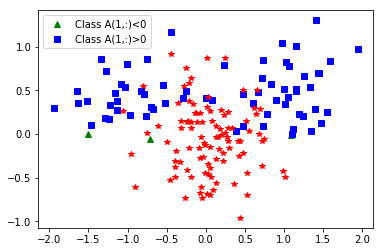

(3, 69)


In [31]:
n=100
scenario=3
sigma_A = 0.4
sigma_B = 0.4
X,T,X_val,T_val = generateSubsets(n,scenario,sigma_A,sigma_B,1)
print(X.shape)

In [32]:
def error_mse(T, Y):
    #return np.sum((T - Y) ** 2) / 2
    return np.mean(((Y-T)**2))

def accuracy(T, Y):
    #return np.sum((T - Y) ** 2) / 2
    return np.sum(abs(T-Y)/2)/len(T)

def phi(x):
    return 2/(1+np.exp(-x))-1


def phi_prime(x):
    return 0.5*((1+phi(x))*(1-phi(x)))

def forward_pass(X,W,V):
    #print(W.shape)
    #print(X.shape)
    H = phi(np.matmul(W,X))
    #print(H.shape)
    H=np.vstack([H,np.ones(np.shape(H)[1])])
    #print(H.shape)
    #print(V.shape)
    O = phi(np.matmul(V,H))
    #print(O.shape)
    return H,O

def backward_pass(O,T,H,V,hidden):
    delta_o = np.multiply((O-T),phi_prime(O))
    #print("hej hopp")
    #print(V.shape)
    #print(delta_y.shape)
    #print(phi_prime(H).shape)
    delta_h = np.multiply(np.matmul(np.transpose(V),delta_o),phi_prime(H))
    delta_h = delta_h[0:hidden]
    return delta_o, delta_h

def update_weights(X,H,W,V,eta,delta_o, delta_h,dw,dv,alpha):
    dw = alpha*dw-(1-alpha)*np.matmul(delta_h,np.transpose(X))
    dv = alpha*dv - (1-alpha)*np.matmul(delta_o,np.transpose(H))
    W = W + dw*eta
    V = V + dv*eta
    return W,V,dw,dv

def backprop(eta,X,T,W,V,hidden,epochs,alpha=0.9):
    weights1 = []
    weights2 = []
    mse_errors = []
    accuracys = []
    #acc = 0
    dw = np.zeros(W.shape)
    dv = np.zeros(V.shape)
    #print(eta,X,T,W,V,hidden,epochs)
    for i in range(epochs):
        weights1.append(W)
        weights2.append(V)
        H,O = forward_pass(X,W,V)
        mse = error_mse(T,O)
        mse_errors.append(mse)
        acc = accuracy(T,O)
        accuracys.append(acc)
        delta_o,delta_h = backward_pass(O,T,H,V,hidden)
        W,V,dw,dv = update_weights(X,H,W,V,eta,delta_o,delta_h,dw,dv,alpha)
        #print(H)
        #print("print")
        #print(Y)
    weights1.append(W)
    weights2.append(V)
        
    return weights1, weights2,mse_errors,accuracys


In [33]:
def weights_init_MLP(n_in,n_out,scale,hidden):
    W = scale*np.random.randn(hidden,n_in)
    V = scale*np.random.randn(n_out,hidden+1)
    return W,V

In [34]:
def predict(validation,W,V, classification = True):
        #print(validation)
        #print(W.shape)
        _, prediction = forward_pass(validation,W,V)
        
        return prediction

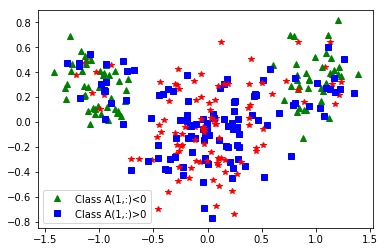

In [37]:
eta = 1e-2
nData = 40
sigma_A = 0.2
sigma_B = 0.3
n_out = 1
scale = 1e-2
#hidden_perceptrons = [2,4,6,8]
hidden_perceptrons = [10,20,40,80]
scenarios = [0,1,2,3]
epochs = 1000

mse_holder = np.zeros((len(hidden_perceptrons),epochs))
mse_val_holder = np.zeros((len(hidden_perceptrons),epochs))
acc_holder = np.zeros((len(hidden_perceptrons),epochs))
acc_val_holder = np.zeros((len(hidden_perceptrons),epochs))

mse_data = np.zeros((len(hidden_perceptrons),epochs,len(scenarios)))
mse_val_data = np.zeros((len(hidden_perceptrons),epochs,len(scenarios)))
acc_data = np.zeros((len(hidden_perceptrons),epochs,len(scenarios)))
acc_val_data = np.zeros((len(hidden_perceptrons),epochs,len(scenarios)))


#FOR ALL DIFFERENT SUBSETS
for s,dataset in enumerate(scenarios):
    X,T,val_X,val_T = generateSubsets(nData,dataset,sigma_A,sigma_B,1)
    n_in = np.shape(X)[0]
    
    #FOR ALL DIFFERENT NUMBER OF PERCEPTRONS IN HIDDEN LAYER
    for j,nPerceptron in enumerate(hidden_perceptrons):
        W,V = weights_init_MLP(n_in,n_out,scale,nPerceptron)
        W=np.random.randn(hidden_perceptrons[j],np.shape(X)[0])
        V=np.random.randn(1,hidden_perceptrons[j]+1)
        #W = scale*np.random.randn(hidden_perceptrons,np.shape(X)[0])
        #V = scale*np.random.randn(n_out,hidden_perceptrons+1)
        
        #TRAINING
        W_train,V_train,mse,acc = backprop(eta,X,T,W,V,nPerceptron,epochs)

        mse_val = []
        acc_val = []
        W_train = np.array(W_train)
        V_train = np.array(V_train)
        
        #print(W_train[i,:,:].shape)
        
        #PREDICTION
        for i in range(1,W_train.shape[0]):
            p = predict(val_X,W_train[i,:,:],V_train[i,:,:])
            mse_val.append(error_mse(val_T,p))
            acc_val.append(accuracy(val_T,p))
            
        mse_holder[j,:] = mse
        mse_val_holder[j,:] = np.array(mse_val)
        acc_holder[j,:] = acc
        acc_val_holder[j,:] = np.array(acc_val)
    
    mse_data[:,:,s] = mse_holder
    mse_val_data[:,:,s] = mse_val_holder
    acc_data[:,:,s] = acc_holder
    acc_val_data[:,:,s] = acc_val_holder
        
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

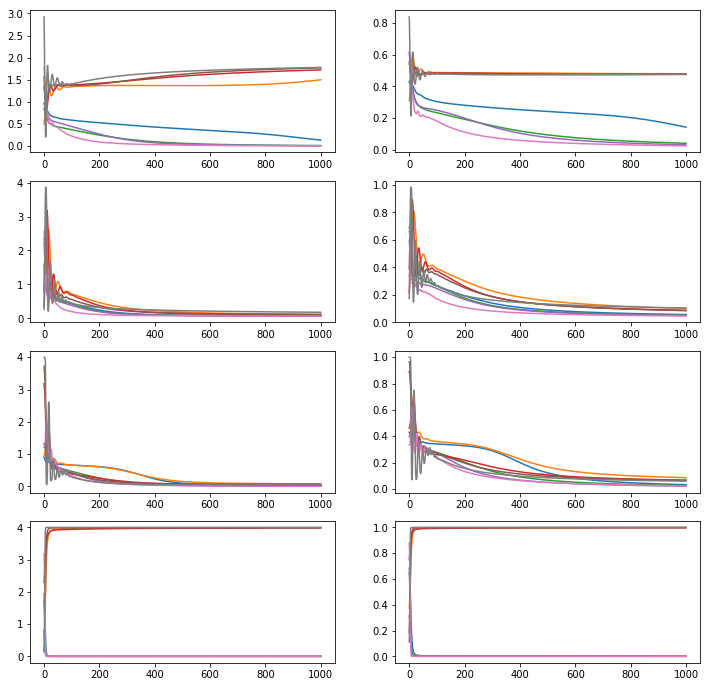

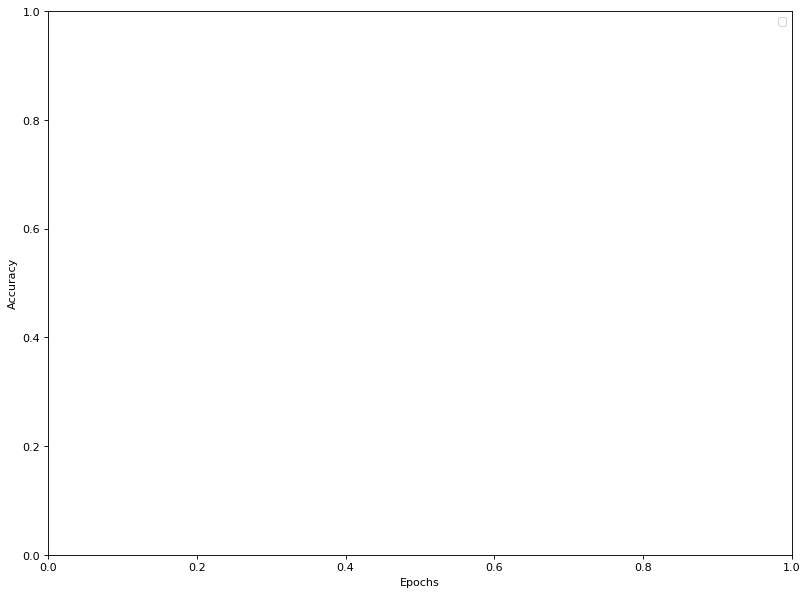

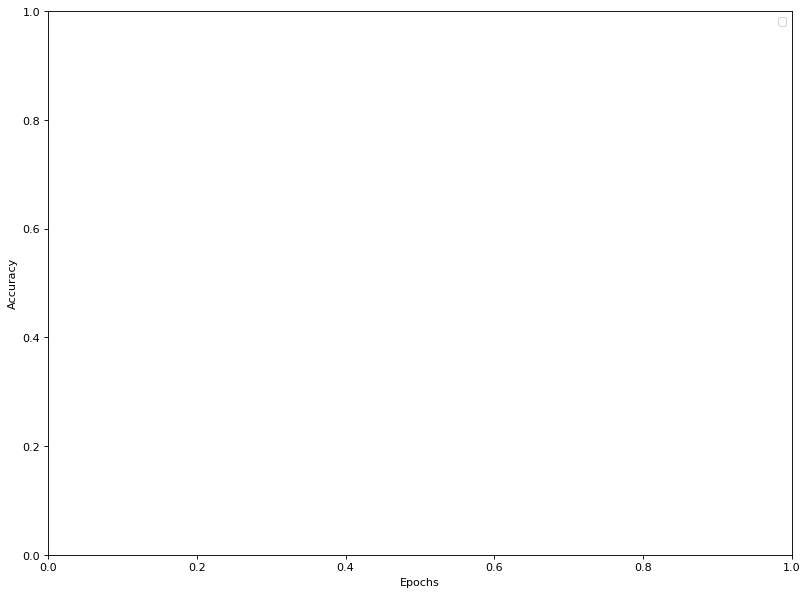

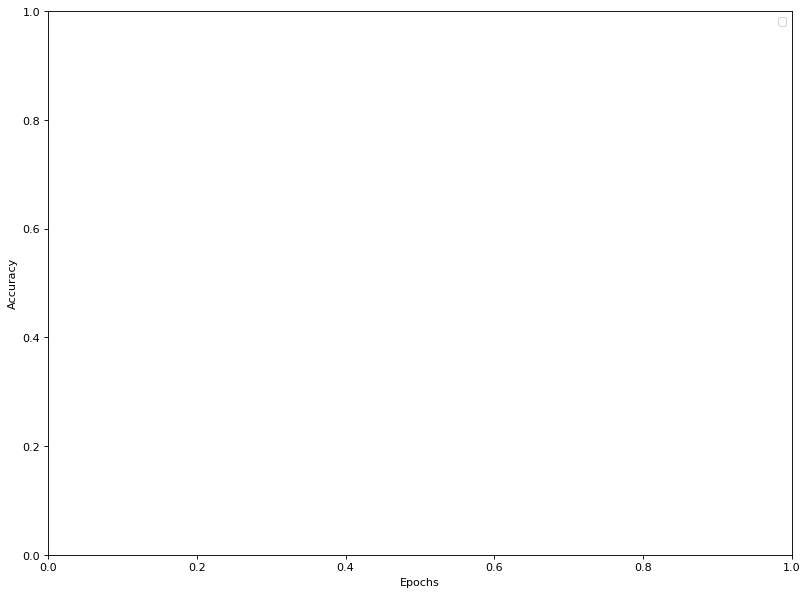

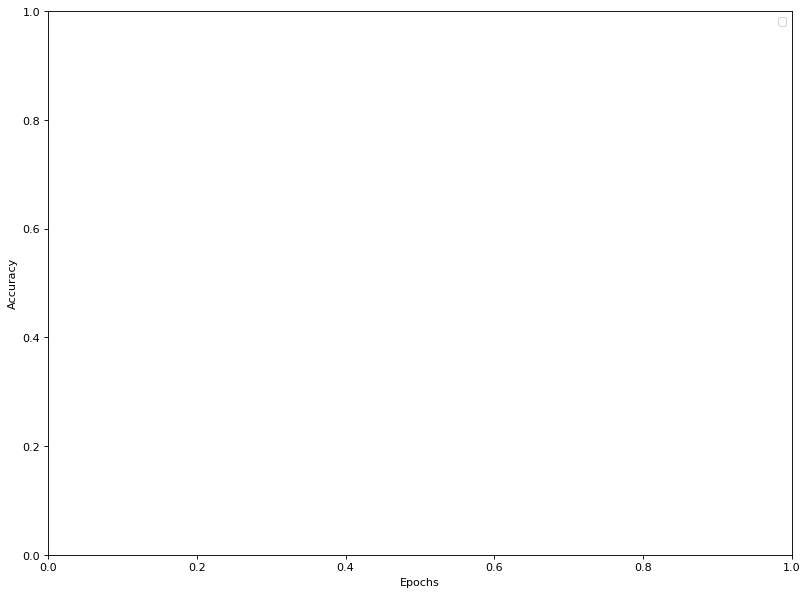

In [36]:
fig = plt.figure(figsize=(24,24))
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)

for plots in range(mse_data.shape[0]):
    
    ax1.plot(np.linspace(0,epochs,epochs),mse_data[plots,:,0], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    ax1.plot(np.linspace(0,epochs,epochs),mse_val_data[plots,:,0], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    
    ax2.plot(np.linspace(0,epochs,epochs),acc_data[plots,:,0], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    ax2.plot(np.linspace(0,epochs,epochs),acc_val_data[plots,:,0], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    ax3.plot(np.linspace(0,epochs,epochs),mse_data[plots,:,1], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    ax3.plot(np.linspace(0,epochs,epochs),mse_val_data[plots,:,1], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    
    ax4.plot(np.linspace(0,epochs,epochs),acc_data[plots,:,1], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    ax4.plot(np.linspace(0,epochs,epochs),acc_val_data[plots,:,1], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    ax5.plot(np.linspace(0,epochs,epochs),mse_data[plots,:,2], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    ax5.plot(np.linspace(0,epochs,epochs),mse_val_data[plots,:,2], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    
    ax6.plot(np.linspace(0,epochs,epochs),acc_data[plots,:,2], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    ax6.plot(np.linspace(0,epochs,epochs),acc_val_data[plots,:,2], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    ax7.plot(np.linspace(0,epochs,epochs),mse_data[plots,:,3], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    ax7.plot(np.linspace(0,epochs,epochs),mse_val_data[plots,:,3], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    
    ax8.plot(np.linspace(0,epochs,epochs),acc_data[plots,:,3], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    ax8.plot(np.linspace(0,epochs,epochs),acc_val_data[plots,:,3], label='nPerceptrons=' + str(hidden_perceptrons[plots]))
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
                 

plt.show()

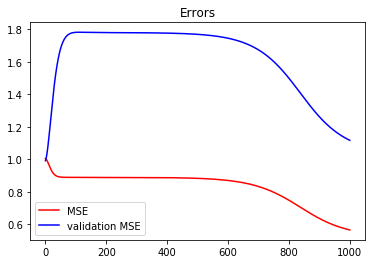

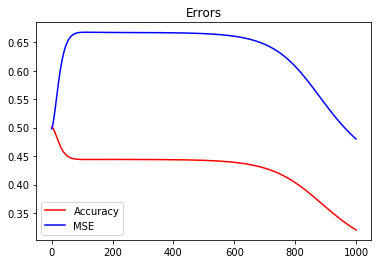

In [30]:
plt_mse, = plt.plot(np.linspace(0,epochs,epochs),mse,'r', label='MSE')
plt_mse_val, = plt.plot(np.linspace(0,epochs,epochs),mse_val,'b', label='validation MSE')
plt.legend(handles=[plt_mse,plt_mse_val])
#plt.axis([0,20,0,100])
plt.title('Errors')
plt.show()
plt_acc, = plt.plot(np.linspace(0,epochs,epochs),acc,'r',label='Accuracy')
plt_acc_val, = plt.plot(np.linspace(0,epochs,epochs),acc_val,'b', label='MSE')
plt.legend(handles=[plt_acc,plt_acc_val])
plt.title('Errors')
plt.show()

0.0